### Install Python libraries

In [ ]:
%pip install --upgrade --quiet  O365
%pip install --upgrade --quiet  beautifulsoup4  # This is optional but is useful for parsing HTML messages
%pip install -qU langchain-community
%pip install trustcall python-dotenv langchain langchain-community langchain-openai langchain-core langgraph msgraph-sdk azure-identity msal msal-extensions microsoft-kiota-abstractions requests
%pip install langgraph-checkpoint-cosmosdb
%pip install psycopg[binary,pool]
%pip install langgraph-checkpoint-postgres

### Add Microsoft Graph Integration to create calendar events and read user calendar
https://python.langchain.com/docs/integrations/tools/office365/

In [ ]:
from dotenv import load_dotenv
from O365 import Account
import os
from langchain_core.tools import tool

#
# Authenticate user with M365
#
scopes = ['User.Read', 'Calendars.Read', 'Calendars.ReadBasic', 'Contacts.Read', 'Calendars.ReadWrite']

#load the environment
load_dotenv(override=True)

# Create credentials tuple for O365 with tenant-specific configuration
CLIENT_ID = os.getenv("CLIENT_ID")  # Use appropriate env var names
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
credentials = (CLIENT_ID, CLIENT_SECRET)

# Initialize O365 Account with tenant-specific settings
account = Account(
    credentials, 
    tenant_id=TENANT_ID,  # Add tenant_id parameter
    auth_flow_type='authorization'  # Explicitly set auth flow
)

# Authenticate with the account
if not account.is_authenticated:
    # This will open a browser for authentication
    account.authenticate(requested_scopes=scopes)  # Use the defined scopes here
    print("Authentication completed")
else:
    print("Already authenticated")
if hasattr(account.connection, 'username'):
    print(f"Value: {account.connection.username}")

### Add Azure PostgreSQL integration for long term memory

In [4]:
from psycopg import connect
from langgraph.store.postgres import PostgresStore
import os

POSTGRES_HOST = os.getenv("POSTGRES_HOST")
POSTGRES_PORT = os.getenv("POSTGRES_PORT")
POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")

# Construct the PostgreSQL connection string for Azure
postgres_connection_string = (
    f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@"
    f"{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}?sslmode=require"
)

pg_conn = connect(postgres_connection_string)
pg_conn.autocommit = True
across_thread_memory = PostgresStore(pg_conn)
across_thread_memory.setup()

### Add CosmosDB integration for short term memory store
https://pypi.org/project/langgraph-checkpoint-cosmosdb/0.2.4/

In [5]:
from langgraph_checkpoint_cosmosdb import CosmosDBSaver
cosmosdb_saver = CosmosDBSaver(database_name="langchaindb", container_name="checkpoints")

### Main code for AI Assistant agent workflow

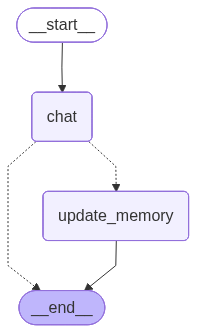

In [6]:
from langchain_core.tools import tool
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage
from langgraph.store.memory import InMemoryStore
from trustcall import create_extractor
from typing import List, Optional
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from datetime import datetime as dt, timedelta
import zoneinfo

def get_ordinal_date(date):
    day = date.day
    if 4 <= day <= 20 or 24 <= day <= 30:
        suffix = "th"
    else:
        suffix = ["st", "nd", "rd"][day % 10 - 1]
    return date.strftime(f"%d{suffix} %B %Y")

class UserProfile(BaseModel):
    name: str = Field(
        description="The user's preferred name.",
    )
    email: str = Field(
        description="The user's primary email address.",
        pattern=r"^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$",
    )
    role: Optional[str] = Field(
        description="The user's role or job title (e.g., 'Software Engineer', 'Product Manager').",
    )
    hobbies: Optional[List[str]] = Field(
        description="A list of the user's hobbies or interests.",
    )
    timezone: Optional[str] = Field(
        description="The user's preferred timezone (e.g., 'Europe/Berlin').",
        pattern=r"^[A-Za-z_]+/[A-Za-z_]+$",
    )
    working_hours: Optional[str] = Field(
        description="The user's typical working hours (e.g., '09:00-17:00').",
        pattern=r"^\d{2}:\d{2}-\d{2}:\d{2}$",
    )
    contacts: Optional[List[str]] = Field(
        description="A list of important contacts (names or emails) the user interacts with frequently.",
        default_factory=list,
    )
    meeting_preferences: Optional[str] = Field(
        description="Specifies the user's meeting preferences, such as timing or duration (e.g., 'no meetings on Fridays', '30-minute max').",
    )

long_term_memory = InMemoryStore()

model = AzureChatOpenAI(
    azure_deployment="gpt-4.1",
    # azure_deployment="gpt-4.1-mini",
    api_version="2024-12-01-preview",
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

trustcall_extractor = create_extractor(model, tools=[UserProfile])

@tool
def create_calendar_event(subject: str, start: str, end: str, location: str = "", body: str = "", timezone: str = None, attendees: list[str] = None):
    """Create a calendar event in the user's default calendar.

    Args:
        subject: The subject of the event.
        start: Start time in ISO format (e.g., '2025-10-07T10:00:00').
        end: End time in ISO format.
        location: Location of the event.
        body: Description of the event.
        timezone: User's timezone (e.g., 'Europe/London').
        attendees: List of email addresses to invite to the event.
    """
    start_dt = dt.fromisoformat(start)
    end_dt = dt.fromisoformat(end)
    if timezone:
        tz = zoneinfo.ZoneInfo(timezone)
        start_dt = start_dt.replace(tzinfo=tz)
        end_dt = end_dt.replace(tzinfo=tz)
    schedule = account.schedule()
    calendar = schedule.get_default_calendar()
    event = calendar.new_event()
    event.subject = subject
    event.start = start_dt
    event.end = end_dt
    event.location = location
    event.body = body
    if attendees:
        for attendee_email in attendees:
            event.attendees.add(attendee_email)
    event.save()
    attendee_text = f" with {len(attendees)} attendee(s)" if attendees else ""
    return f"Event '{subject}' created successfully from {start} to {end}{attendee_text}."

@tool
def get_calendar_events(days_ahead: int = 14, days_back: int = 0):
    """Retrieve calendar events from the user's default calendar.

    Args:
        days_ahead: Number of days in the future to retrieve events (default: 14).
        days_back: Number of days in the past to retrieve events (default: 0).
    
    Returns:
        A formatted string with all calendar events in the specified time range.
    """
    schedule = account.schedule()
    calendar = schedule.get_default_calendar()
    
    # Calculate the date range
    start_date = dt.now() - timedelta(days=days_back)
    end_date = dt.now() + timedelta(days=days_ahead)
    
    # Get events with proper recurring parameters
    events = list(calendar.get_events(
        include_recurring=True,
        start_recurring=start_date,
        end_recurring=end_date,
        limit=1000
    ))
    
    if not events:
        return f"No events found between {start_date.strftime('%Y-%m-%d')} and {end_date.strftime('%Y-%m-%d')}."
    
    # Sort events by start time
    events.sort(key=lambda e: e.start)
    
    # Format events for display
    event_list = []
    for event in events:
        event_info = f" **{event.subject}**\n"
        event_info += f"   Start: {event.start.strftime('%Y-%m-%d %H:%M')}\n"
        event_info += f"   End: {event.end.strftime('%Y-%m-%d %H:%M')}\n"
        if event.location:
            event_info += f"   Location: {event.location}\n"
        if event.body:
            event_info += f"   Description: {event.body[:100]}...\n" if len(event.body) > 100 else f"   Description: {event.body}\n"
        event_list.append(event_info)
    
    result = f"Found {len(event_list)} event(s):\n\n" + "\n".join(event_list)
    return result

def should_update_profile(state: MessagesState) -> str:
    """Determines if the profile needs updating based on the latest message"""
    # Extract the last user message and AI response
    last_messages = state["messages"][-2:]  # Get last user message and AI response
    
    # Ask the model to make a decision about updating the profile
    decision_prompt = """
    Based on the conversation, determine if there is any new information about the user
    that should be added or updated in their profile. ONLY update if the conversation contains
    information about these specific UserProfile properties:
    
    - name: The user's preferred name
    - email: The user's primary email address
    - role: The user's role or job title (e.g., 'Software Engineer', 'Product Manager')
    - hobbies: A list of the user's hobbies or interests
    - timezone: The user's preferred timezone (e.g., 'Europe/Berlin')
    - working_hours: The user's typical working hours (e.g., '09:00-17:00')
    - contacts: Important contacts (names or emails) the user interacts with frequently
    - communication_preferences: Preferred communication style or channels
    - meeting_preferences: Meeting preferences such as timing or duration
    
    DO NOT update the profile for:
    - Scheduling meetings or calendar events (these are temporary actions, not profile information)
    - General questions or requests that don't reveal personal information
    - Conversations about preferences unrelated to the properties above
    
    Answer with ONLY "UPDATE" or "SKIP".
    """
    
    decision = model.invoke([
        SystemMessage(content=decision_prompt),
        *last_messages
    ])

    if "UPDATE" in decision.content.upper():
        return "update_memory"
    else:
        return END

def chat(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    profile = store.get((user_id, "memory"), "profile")

    if profile:
        profile_content = profile.value
    else:
        profile_content = None

    current_date_str = f"Current date and time is {get_ordinal_date(dt.now())}"

    SYSTEM_MESSAGE = f"""
    You are designed to be a companion to a user, helping them manage their schedule and personal profile.
    Extract and update ONLY the relevant profile information from what the user explicitly shares.

    {current_date_str}

    Examples of what are personal information for personal profile:
    - "I am a Project Manager" (job title)
    - "I like running" (hobby)
    - "I prefer morning meetings" (meeting preference)
    - "I live in London" (location)

    GUIDELINES on what to include in user response:
    - Do not tell the user you have updated the User Profile or show content of User Profile in response to user
    - When the user asks to schedule a meeting or create an event, you MUST use the create_calendar_event tool to create it in the calendar. Do not respond that you scheduled it unless you actually called the tool. Provide start and end times in ISO format based on the current date.
    - When the user asks to see, show, list, or retrieve calendar events or tasks, use the get_calendar_events tool to fetch them from the calendar.

   Here is the current User Profile (may be empty if no information has been collected yet): {profile_content}
    """

    model_with_tools = model.bind_tools([create_calendar_event, get_calendar_events])
    response = model_with_tools.invoke([SystemMessage(content=SYSTEM_MESSAGE)] + state["messages"])

    if response.tool_calls:
        tool_results = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'create_calendar_event':
                if profile_content and 'timezone' in profile_content:
                    tool_call['args']['timezone'] = profile_content['timezone']
                result = create_calendar_event.invoke(tool_call)
                tool_results.append(result)
            elif tool_call['name'] == 'get_calendar_events':
                result = get_calendar_events.invoke(tool_call)
                tool_results.append(result)
        # Add tool results to messages
        new_messages = state["messages"] + [response] + tool_results
        # Get final response
        final_response = model.invoke([SystemMessage(content=SYSTEM_MESSAGE)] + new_messages)
        return {"messages": final_response}
    else:
        return {"messages": response}

def update_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = (user_id, "memory")
    
    existing_profile = store.get(namespace, "profile")
    profile_content = existing_profile.value if existing_profile else None
    
    if profile_content:
        print("Update profile")
        extraction_input = {
            "messages": [SystemMessage(content="Update the user profile (JSON doc) using the user's chat history. Save this for future reference. If a profile already exists, just update it.")] + state['messages'], 
            "existing": {"UserProfile": profile_content}
        }
    else:
        print("Create profile")
        extraction_input = state['messages']
    
    updated_profile = trustcall_extractor.invoke(extraction_input)
    if updated_profile["responses"]:
        store.put(namespace, "profile", updated_profile["responses"][0].model_dump())

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("update_memory", update_memory)
builder.add_edge(START, "chat")
builder.add_conditional_edges(
    "chat",  # Source node
    should_update_profile,    # Router function
    {
        "update_memory": "update_memory",  # If returns "update_memory", go to that node
        END: END               # If returns END, go to end
    }
)

graph = builder.compile(checkpointer=cosmosdb_saver, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# initiate a fresh chat session
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# set up the initial message from user
user_msg = {"messages": HumanMessage(content="""
My name is Rafal Hollins
I live in London and work as a Cloud Architect.
I like gardening.
My working hours are between 09:00-17:00.
My email address is rafal@something.com.
I prefer morning meetings.
""")}

# execute the graph in streaming mode and display output
for chunk in graph.stream(user_msg, config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================


My name is Rafal Hollins
I live in London and work as a Cloud Architect.
I like gardening.
My working hours are between 09:00-17:00.
My email address is rafal@something.com.
I prefer morning meetings.

================================== Ai Message ==================================

Thank you for sharing your information. Is there anything else you'd like to add or update?
Create profile


In [25]:
# initiate a fresh chat session
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# set up the initial message from user
user_msg = {"messages": HumanMessage(content="""
I also like to learn about AI.
""")}

# execute the graph in streaming mode and display output
for chunk in graph.stream(user_msg, config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

In [8]:
# initiate a fresh chat session
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# set up the initial message from user
user_msg = {"messages": HumanMessage(content="""
I need to schedule a meeting with my team and stakeholders next Wednesday between 14:00 and 15:00 to discuss the cloud project called ABC and agree on the next steps.
Please also invite john@company.com and agnes@company.com.
Add agenda which will include review of business requirements, defining project scope, confirmation of kick-off date and agreement on next steps
""")}

# execute the graph in streaming mode and display output
for chunk in graph.stream(user_msg, config, stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================


I need to schedule a meeting with my team and stakeholders next Wednesday between 14:00 and 15:00 to discuss the cloud project called ABC and agree on the next steps.
Please also invite john@company.com and agnes@company.com.
Add agenda which will include review of business requirements, defining project scope, confirmation of kick-off date and agreement on next steps

================================== Ai Message ==================================

Your meeting with the team and stakeholders to discuss Cloud Project ABC has been scheduled for next Wednesday from 14:00 to 15:00. Attendees John and Agnes have been invited, and the agenda covers business requirements, project scope, kick-off date confirmation, and agreeing on the next steps. Let me know if there is anything you'd like to adjust or add.
